In [1]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [2]:
imag_dir = os.path.join(dataset_dir,'images/polymer')
mask_dir = os.path.join(dataset_dir,'mask/polymer')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/polymer C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/polymer
15761
15761


In [3]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [4]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\User\anaconda3\envs\PytorchGPU\lib\site-packages\albumentations\check_version.py:51: UserWarning: Error fetching version info The read operation timed out
  data = fetch_version_info()


[2025-02-15 10:57:41,936: INFO: 3804955329: date_time: 20250215-105741]


In [5]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "linknet",
    "backbone" : "vgg16", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [6]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-02-15 10:57:42,108: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-02-15 10:57:42,109: INFO: 342151172: model_config: {'model_name': 'linknet', 'backbone': 'vgg16', 'weights': 'imagenet', 'in_channels': 3}]
[2025-02-15 10:57:42,110: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-02-15 10:57:42,111: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

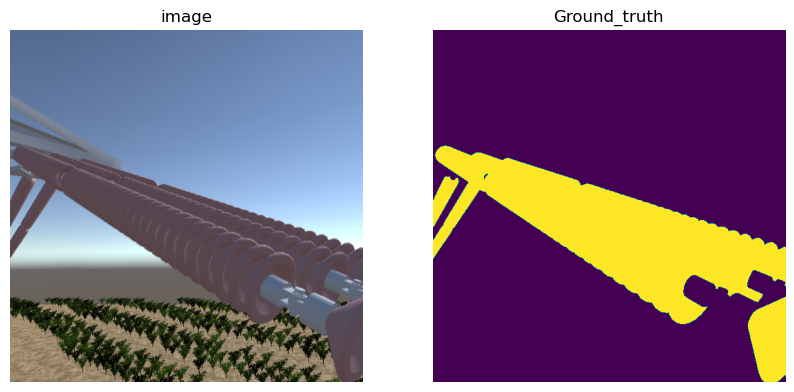

In [7]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [8]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [9]:
x.to_csv('dataset.csv')

In [10]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [11]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [12]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-02-15 10:57:42,681: INFO: 3993860970: data injection started]
[2025-02-15 10:57:42,687: INFO: 3993860970: train data spliting ]
[2025-02-15 10:57:42,690: INFO: 3993860970: val test spliting ]
[2025-02-15 10:57:42,691: INFO: 3993860970: csv saving started]
[2025-02-15 10:57:42,730: INFO: 3993860970: train csv done ]
[2025-02-15 10:57:42,736: INFO: 3993860970: val csv done ]
[2025-02-15 10:57:42,742: INFO: 3993860970: test csv done]


In [13]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [14]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [15]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [17]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [18]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 2102/2102 [09:33<00:00,  3.66it/s, epoch=0, train_loss=0.0284, train_Miou_score=0.488, train_dice_score=0.718, train_acc=0.981, train_binary_jaccard_index=0.874, train_dice_coefficient=0.929]

[2025-02-15 11:08:27,600: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.02844133907902479]
[2025-02-15 11:08:27,600: INFO: 2273413975: train_loss 0.06459250288053628]
[2025-02-15 11:08:27,601: INFO: 2273413975: train_Miou_score 0.4881130636489811]
[2025-02-15 11:08:27,601: INFO: 2273413975: train_dice_score 0.7182391604016952]
[2025-02-15 11:08:27,601: INFO: 2273413975: train_acc 0.9810053330733592]
[2025-02-15 11:08:27,603: INFO: 2273413975: train_binary_jaccard_index: 0.8739948951409727]
[2025-02-15 11:08:27,603: INFO: 2273413975: train_dice_coefficient: 0.9287148956618881]



100%|██████████| 788/788 [00:49<00:00, 16.01it/s, epoch=0, eval_loss=0.00951, eval_Miou_score=0.517, eval_dice_score=0.785, eval_acc=0.991, eval_binary_jaccard_index=0.932, eval_dice_coefficient=0.963]

[2025-02-15 11:09:16,823: INFO: 2273413975: Epoch: 0 | Loss: 0.009510793132225269]
[2025-02-15 11:09:16,824: INFO: 2273413975: eval_loss 0.00968150082378938]
[2025-02-15 11:09:16,825: INFO: 2273413975: eval_Miou_score 0.5170932144758665]
[2025-02-15 11:09:16,826: INFO: 2273413975: eval_dice_score 0.7845034636368001]
[2025-02-15 11:09:16,827: INFO: 2273413975: eval_acc 0.9907335944587204]
[2025-02-15 11:09:16,828: INFO: 2273413975: eval_binary_jaccard_index: 0.9316970001773786]
[2025-02-15 11:09:16,829: INFO: 2273413975: eval_dice_coefficient: 0.9626582769042036]



100%|██████████| 2102/2102 [09:34<00:00,  3.66it/s, epoch=1, train_loss=0.00878, train_Miou_score=0.503, train_dice_score=0.76, train_acc=0.986, train_binary_jaccard_index=0.906, train_dice_coefficient=0.948] 

[2025-02-15 11:18:51,104: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.008784817327895015]
[2025-02-15 11:18:51,105: INFO: 2273413975: train_loss 0.037049906931297116]
[2025-02-15 11:18:51,106: INFO: 2273413975: train_Miou_score 0.5034056818600102]
[2025-02-15 11:18:51,106: INFO: 2273413975: train_dice_score 0.7598264918465001]
[2025-02-15 11:18:51,107: INFO: 2273413975: train_acc 0.9861784637059403]
[2025-02-15 11:18:51,109: INFO: 2273413975: train_binary_jaccard_index: 0.9058125735846279]
[2025-02-15 11:18:51,109: INFO: 2273413975: train_dice_coefficient: 0.947752088935954]



100%|██████████| 788/788 [00:48<00:00, 16.31it/s, epoch=1, eval_loss=0.00758, eval_Miou_score=0.518, eval_dice_score=0.807, eval_acc=0.992, eval_binary_jaccard_index=0.938, eval_dice_coefficient=0.966]

[2025-02-15 11:19:39,418: INFO: 2273413975: Epoch: 1 | Loss: 0.007576084076450561]
[2025-02-15 11:19:39,419: INFO: 2273413975: eval_loss 0.008401745545289411]
[2025-02-15 11:19:39,419: INFO: 2273413975: eval_Miou_score 0.5175686991645903]
[2025-02-15 11:19:39,420: INFO: 2273413975: eval_dice_score 0.807378664764051]
[2025-02-15 11:19:39,421: INFO: 2273413975: eval_acc 0.991609280484582]
[2025-02-15 11:19:39,421: INFO: 2273413975: eval_binary_jaccard_index: 0.9378641634082734]
[2025-02-15 11:19:39,422: INFO: 2273413975: eval_dice_coefficient: 0.9659061019077849]



100%|██████████| 2102/2102 [09:10<00:00,  3.82it/s, epoch=2, train_loss=0.00744, train_Miou_score=0.51, train_dice_score=0.779, train_acc=0.988, train_binary_jaccard_index=0.919, train_dice_coefficient=0.956] 

[2025-02-15 11:28:49,873: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.007439556885173954]
[2025-02-15 11:28:49,874: INFO: 2273413975: train_loss 0.027213841317416783]
[2025-02-15 11:28:49,874: INFO: 2273413975: train_Miou_score 0.5100486727766373]
[2025-02-15 11:28:49,875: INFO: 2273413975: train_dice_score 0.7787430632128116]
[2025-02-15 11:28:49,876: INFO: 2273413975: train_acc 0.9883209476669819]
[2025-02-15 11:28:49,876: INFO: 2273413975: train_binary_jaccard_index: 0.9194860893499273]
[2025-02-15 11:28:49,877: INFO: 2273413975: train_dice_coefficient: 0.9557915151055608]



100%|██████████| 788/788 [00:47<00:00, 16.54it/s, epoch=2, eval_loss=0.00683, eval_Miou_score=0.522, eval_dice_score=0.819, eval_acc=0.992, eval_binary_jaccard_index=0.943, eval_dice_coefficient=0.969]

[2025-02-15 11:29:37,534: INFO: 2273413975: Epoch: 2 | Loss: 0.006832694871171477]


[2025-02-15 11:29:37,535: INFO: 2273413975: eval_loss 0.007767175929237765]
[2025-02-15 11:29:37,535: INFO: 2273413975: eval_Miou_score 0.5217192307959252]
[2025-02-15 11:29:37,536: INFO: 2273413975: eval_dice_score 0.818823196485563]
[2025-02-15 11:29:37,536: INFO: 2273413975: eval_acc 0.9921365736301377]
[2025-02-15 11:29:37,537: INFO: 2273413975: eval_binary_jaccard_index: 0.9431537822040205]
[2025-02-15 11:29:37,537: INFO: 2273413975: eval_dice_coefficient: 0.9687654166151124]


100%|██████████| 2102/2102 [09:10<00:00,  3.82it/s, epoch=3, train_loss=0.00686, train_Miou_score=0.514, train_dice_score=0.789, train_acc=0.99, train_binary_jaccard_index=0.927, train_dice_coefficient=0.96]  

[2025-02-15 11:38:47,606: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.00685749490072793]
[2025-02-15 11:38:47,608: INFO: 2273413975: train_loss 0.02209601779628]
[2025-02-15 11:38:47,609: INFO: 2273413975: train_Miou_score 0.5137276012046381]
[2025-02-15 11:38:47,609: INFO: 2273413975: train_dice_score 0.7886051431849429]
[2025-02-15 11:38:47,610: INFO: 2273413975: train_acc 0.9895321361359021]
[2025-02-15 11:38:47,611: INFO: 2273413975: train_binary_jaccard_index: 0.927104137061637]
[2025-02-15 11:38:47,612: INFO: 2273413975: train_dice_coefficient: 0.9602266302132995]



100%|██████████| 788/788 [00:48<00:00, 16.42it/s, epoch=3, eval_loss=0.00691, eval_Miou_score=0.52, eval_dice_score=0.821, eval_acc=0.992, eval_binary_jaccard_index=0.944, eval_dice_coefficient=0.969] 

[2025-02-15 11:39:35,619: INFO: 2273413975: Epoch: 3 | Loss: 0.006912920453826788]
[2025-02-15 11:39:35,620: INFO: 2273413975: eval_loss 0.007781454351086671]
[2025-02-15 11:39:35,621: INFO: 2273413975: eval_Miou_score 0.5201708178182468]
[2025-02-15 11:39:35,621: INFO: 2273413975: eval_dice_score 0.8210147541385088]
[2025-02-15 11:39:35,622: INFO: 2273413975: eval_acc 0.9923815025290862]
[2025-02-15 11:39:35,622: INFO: 2273413975: eval_binary_jaccard_index: 0.9443614917055605]
[2025-02-15 11:39:35,623: INFO: 2273413975: eval_dice_coefficient: 0.9694678480068183]



100%|██████████| 2102/2102 [09:10<00:00,  3.82it/s, epoch=4, train_loss=0.00526, train_Miou_score=0.517, train_dice_score=0.798, train_acc=0.991, train_binary_jaccard_index=0.934, train_dice_coefficient=0.964]

[2025-02-15 11:48:46,288: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.005263141940368231]
[2025-02-15 11:48:46,290: INFO: 2273413975: train_loss 0.01875899133550283]
[2025-02-15 11:48:46,292: INFO: 2273413975: train_Miou_score 0.5168913114465042]
[2025-02-15 11:48:46,294: INFO: 2273413975: train_dice_score 0.7982821119210189]
[2025-02-15 11:48:46,295: INFO: 2273413975: train_acc 0.9905763745478059]
[2025-02-15 11:48:46,296: INFO: 2273413975: train_binary_jaccard_index: 0.9339010509136855]
[2025-02-15 11:48:46,297: INFO: 2273413975: train_dice_coefficient: 0.9641181391697417]



100%|██████████| 788/788 [00:47<00:00, 16.50it/s, epoch=4, eval_loss=0.00316, eval_Miou_score=0.523, eval_dice_score=0.831, eval_acc=0.993, eval_binary_jaccard_index=0.95, eval_dice_coefficient=0.973] 

[2025-02-15 11:49:34,056: INFO: 2273413975: Epoch: 4 | Loss: 0.0031607368119477017]
[2025-02-15 11:49:34,057: INFO: 2273413975: eval_loss 0.006887433442507881]
[2025-02-15 11:49:34,057: INFO: 2273413975: eval_Miou_score 0.5229463950102099]
[2025-02-15 11:49:34,057: INFO: 2273413975: eval_dice_score 0.8312070076349121]
[2025-02-15 11:49:34,058: INFO: 2273413975: eval_acc 0.9932751975083715]
[2025-02-15 11:49:34,059: INFO: 2273413975: eval_binary_jaccard_index: 0.9504908819337787]
[2025-02-15 11:49:34,059: INFO: 2273413975: eval_dice_coefficient: 0.9730026674234408]



100%|██████████| 2102/2102 [09:11<00:00,  3.81it/s, epoch=5, train_loss=0.00553, train_Miou_score=0.519, train_dice_score=0.804, train_acc=0.991, train_binary_jaccard_index=0.938, train_dice_coefficient=0.967]

[2025-02-15 11:58:45,149: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.005526001032594268]
[2025-02-15 11:58:45,150: INFO: 2273413975: train_loss 0.016522827605857035]
[2025-02-15 11:58:45,151: INFO: 2273413975: train_Miou_score 0.51875611434815]
[2025-02-15 11:58:45,152: INFO: 2273413975: train_dice_score 0.8044515966895296]
[2025-02-15 11:58:45,153: INFO: 2273413975: train_acc 0.9912280255779174]
[2025-02-15 11:58:45,154: INFO: 2273413975: train_binary_jaccard_index: 0.9381631619606818]
[2025-02-15 11:58:45,154: INFO: 2273413975: train_dice_coefficient: 0.9665456302685898]



100%|██████████| 788/788 [00:48<00:00, 16.20it/s, epoch=5, eval_loss=0.0105, eval_Miou_score=0.518, eval_dice_score=0.822, eval_acc=0.993, eval_binary_jaccard_index=0.945, eval_dice_coefficient=0.97]  

[2025-02-15 11:59:33,804: INFO: 2273413975: Epoch: 5 | Loss: 0.010500769551635394]
[2025-02-15 11:59:33,805: INFO: 2273413975: eval_loss 0.007446401906840199]
[2025-02-15 11:59:33,806: INFO: 2273413975: eval_Miou_score 0.5183521480868412]
[2025-02-15 11:59:33,806: INFO: 2273413975: eval_dice_score 0.8220025513182487]
[2025-02-15 11:59:33,807: INFO: 2273413975: eval_acc 0.9926480274716811]
[2025-02-15 11:59:33,808: INFO: 2273413975: eval_binary_jaccard_index: 0.945145248900311]
[2025-02-15 11:59:33,809: INFO: 2273413975: eval_dice_coefficient: 0.9699092700944897]



100%|██████████| 2102/2102 [09:11<00:00,  3.81it/s, epoch=6, train_loss=0.00493, train_Miou_score=0.521, train_dice_score=0.81, train_acc=0.992, train_binary_jaccard_index=0.942, train_dice_coefficient=0.969] 

[2025-02-15 12:08:45,794: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.004926214379202628]
[2025-02-15 12:08:45,794: INFO: 2273413975: train_loss 0.014870990908744776]
[2025-02-15 12:08:45,795: INFO: 2273413975: train_Miou_score 0.5206203627994693]
[2025-02-15 12:08:45,796: INFO: 2273413975: train_dice_score 0.8098751199747559]
[2025-02-15 12:08:45,797: INFO: 2273413975: train_acc 0.9917786193271524]
[2025-02-15 12:08:45,798: INFO: 2273413975: train_binary_jaccard_index: 0.9417735737972128]
[2025-02-15 12:08:45,798: INFO: 2273413975: train_dice_coefficient: 0.9685954277998221]



100%|██████████| 788/788 [00:48<00:00, 16.25it/s, epoch=6, eval_loss=0.00665, eval_Miou_score=0.518, eval_dice_score=0.822, eval_acc=0.993, eval_binary_jaccard_index=0.946, eval_dice_coefficient=0.97]

[2025-02-15 12:09:34,297: INFO: 2273413975: Epoch: 6 | Loss: 0.006647579182828139]
[2025-02-15 12:09:34,298: INFO: 2273413975: eval_loss 0.007277490622455128]
[2025-02-15 12:09:34,299: INFO: 2273413975: eval_Miou_score 0.5184645192120886]
[2025-02-15 12:09:34,299: INFO: 2273413975: eval_dice_score 0.8220811551051826]
[2025-02-15 12:09:34,300: INFO: 2273413975: eval_acc 0.9927501101006279]
[2025-02-15 12:09:34,300: INFO: 2273413975: eval_binary_jaccard_index: 0.9456507281803453]


[2025-02-15 12:09:34,301: INFO: 2273413975: eval_dice_coefficient: 0.9701908861454591]


100%|██████████| 2102/2102 [09:11<00:00,  3.81it/s, epoch=7, train_loss=0.00442, train_Miou_score=0.522, train_dice_score=0.815, train_acc=0.992, train_binary_jaccard_index=0.945, train_dice_coefficient=0.97] 

[2025-02-15 12:18:45,596: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.004419113884189943]
[2025-02-15 12:18:45,597: INFO: 2273413975: train_loss 0.013592281399255406]
[2025-02-15 12:18:45,597: INFO: 2273413975: train_Miou_score 0.5218938912568946]
[2025-02-15 12:18:45,598: INFO: 2273413975: train_dice_score 0.8152456339284756]
[2025-02-15 12:18:45,599: INFO: 2273413975: train_acc 0.9922546862769025]
[2025-02-15 12:18:45,600: INFO: 2273413975: train_binary_jaccard_index: 0.9449136170419509]
[2025-02-15 12:18:45,600: INFO: 2273413975: train_dice_coefficient: 0.9703738876309557]



100%|██████████| 788/788 [00:48<00:00, 16.33it/s, epoch=7, eval_loss=0.00376, eval_Miou_score=0.52, eval_dice_score=0.826, eval_acc=0.993, eval_binary_jaccard_index=0.949, eval_dice_coefficient=0.972] 

[2025-02-15 12:19:33,865: INFO: 2273413975: Epoch: 7 | Loss: 0.0037592232681167913]
[2025-02-15 12:19:33,866: INFO: 2273413975: eval_loss 0.0068287901846591425]
[2025-02-15 12:19:33,866: INFO: 2273413975: eval_Miou_score 0.5200317552015374]
[2025-02-15 12:19:33,867: INFO: 2273413975: eval_dice_score 0.8259236397160227]
[2025-02-15 12:19:33,868: INFO: 2273413975: eval_acc 0.9931875016483559]
[2025-02-15 12:19:33,869: INFO: 2273413975: eval_binary_jaccard_index: 0.9486436976644631]
[2025-02-15 12:19:33,869: INFO: 2273413975: eval_dice_coefficient: 0.9719263953363622]



100%|██████████| 2102/2102 [09:12<00:00,  3.81it/s, epoch=8, train_loss=0.00474, train_Miou_score=0.523, train_dice_score=0.819, train_acc=0.993, train_binary_jaccard_index=0.947, train_dice_coefficient=0.972]

[2025-02-15 12:28:46,160: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.004739850107314585]
[2025-02-15 12:28:46,161: INFO: 2273413975: train_loss 0.012615985252723573]
[2025-02-15 12:28:46,162: INFO: 2273413975: train_Miou_score 0.5231174712425458]
[2025-02-15 12:28:46,163: INFO: 2273413975: train_dice_score 0.8188486004970753]
[2025-02-15 12:28:46,164: INFO: 2273413975: train_acc 0.99258929522865]
[2025-02-15 12:28:46,165: INFO: 2273413975: train_binary_jaccard_index: 0.9471466740571063]
[2025-02-15 12:28:46,166: INFO: 2273413975: train_dice_coefficient: 0.9716331427689585]



100%|██████████| 788/788 [00:48<00:00, 16.25it/s, epoch=8, eval_loss=0.00326, eval_Miou_score=0.522, eval_dice_score=0.831, eval_acc=0.994, eval_binary_jaccard_index=0.951, eval_dice_coefficient=0.974]

[2025-02-15 12:29:34,648: INFO: 2273413975: Epoch: 8 | Loss: 0.0032588885671596237]
[2025-02-15 12:29:34,649: INFO: 2273413975: eval_loss 0.006410040726547024]
[2025-02-15 12:29:34,651: INFO: 2273413975: eval_Miou_score 0.5217497282747119]
[2025-02-15 12:29:34,651: INFO: 2273413975: eval_dice_score 0.8305244907060216]
[2025-02-15 12:29:34,652: INFO: 2273413975: eval_acc 0.993582772321104]
[2025-02-15 12:29:34,653: INFO: 2273413975: eval_binary_jaccard_index: 0.9513730596639615]
[2025-02-15 12:29:34,653: INFO: 2273413975: eval_dice_coefficient: 0.9735002296250715]



100%|██████████| 2102/2102 [09:12<00:00,  3.81it/s, epoch=9, train_loss=0.00419, train_Miou_score=0.524, train_dice_score=0.822, train_acc=0.993, train_binary_jaccard_index=0.949, train_dice_coefficient=0.973]

[2025-02-15 12:38:46,848: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.0041945713344468715]
[2025-02-15 12:38:46,850: INFO: 2273413975: train_loss 0.011795639464147193]
[2025-02-15 12:38:46,851: INFO: 2273413975: train_Miou_score 0.5243459763907456]
[2025-02-15 12:38:46,852: INFO: 2273413975: train_dice_score 0.8224470619721911]
[2025-02-15 12:38:46,852: INFO: 2273413975: train_acc 0.992911564643104]
[2025-02-15 12:38:46,853: INFO: 2273413975: train_binary_jaccard_index: 0.9492698572257039]
[2025-02-15 12:38:46,854: INFO: 2273413975: train_dice_coefficient: 0.972828940306143]



100%|██████████| 788/788 [00:49<00:00, 15.98it/s, epoch=9, eval_loss=0.0034, eval_Miou_score=0.523, eval_dice_score=0.834, eval_acc=0.994, eval_binary_jaccard_index=0.954, eval_dice_coefficient=0.975] 

[2025-02-15 12:39:36,184: INFO: 2273413975: Epoch: 9 | Loss: 0.0034027073891634866]
[2025-02-15 12:39:36,185: INFO: 2273413975: eval_loss 0.006108042231270564]
[2025-02-15 12:39:36,185: INFO: 2273413975: eval_Miou_score 0.5234581036899749]
[2025-02-15 12:39:36,186: INFO: 2273413975: eval_dice_score 0.8335302876469296]
[2025-02-15 12:39:36,186: INFO: 2273413975: eval_acc 0.9938846663170054]
[2025-02-15 12:39:36,187: INFO: 2273413975: eval_binary_jaccard_index: 0.9535183859071907]
[2025-02-15 12:39:36,187: INFO: 2273413975: eval_dice_coefficient: 0.9747444116812378]



100%|██████████| 2102/2102 [09:12<00:00,  3.81it/s, epoch=10, train_loss=0.00413, train_Miou_score=0.525, train_dice_score=0.825, train_acc=0.993, train_binary_jaccard_index=0.951, train_dice_coefficient=0.974]

[2025-02-15 12:48:48,216: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.004131874904305905]
[2025-02-15 12:48:48,217: INFO: 2273413975: train_loss 0.011149278389638915]
[2025-02-15 12:48:48,218: INFO: 2273413975: train_Miou_score 0.5251802441034646]
[2025-02-15 12:48:48,219: INFO: 2273413975: train_dice_score 0.8254101710050368]
[2025-02-15 12:48:48,220: INFO: 2273413975: train_acc 0.9931808520911134]
[2025-02-15 12:48:48,221: INFO: 2273413975: train_binary_jaccard_index: 0.9510980267630307]
[2025-02-15 12:48:48,222: INFO: 2273413975: train_dice_coefficient: 0.9738574854415125]



100%|██████████| 788/788 [00:48<00:00, 16.38it/s, epoch=10, eval_loss=0.00463, eval_Miou_score=0.524, eval_dice_score=0.836, eval_acc=0.994, eval_binary_jaccard_index=0.955, eval_dice_coefficient=0.975]

[2025-02-15 12:49:36,342: INFO: 2273413975: Epoch: 10 | Loss: 0.004632521855649609]
[2025-02-15 12:49:36,343: INFO: 2273413975: eval_loss 0.005971245686526145]
[2025-02-15 12:49:36,343: INFO: 2273413975: eval_Miou_score 0.5244496577622624]
[2025-02-15 12:49:36,344: INFO: 2273413975: eval_dice_score 0.8355849875359833]
[2025-02-15 12:49:36,344: INFO: 2273413975: eval_acc 0.9940198542722976]
[2025-02-15 12:49:36,345: INFO: 2273413975: eval_binary_jaccard_index: 0.9546266436631854]
[2025-02-15 12:49:36,346: INFO: 2273413975: eval_dice_coefficient: 0.9753507901792907]



100%|██████████| 2102/2102 [09:12<00:00,  3.80it/s, epoch=11, train_loss=0.0036, train_Miou_score=0.526, train_dice_score=0.829, train_acc=0.993, train_binary_jaccard_index=0.953, train_dice_coefficient=0.975] 

[2025-02-15 12:58:49,216: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.0036046458186704015]
[2025-02-15 12:58:49,216: INFO: 2273413975: train_loss 0.010534681491054828]
[2025-02-15 12:58:49,217: INFO: 2273413975: train_Miou_score 0.5259399874601957]
[2025-02-15 12:58:49,218: INFO: 2273413975: train_dice_score 0.8285456470376583]
[2025-02-15 12:58:49,218: INFO: 2273413975: train_acc 0.9934490975022051]
[2025-02-15 12:58:49,219: INFO: 2273413975: train_binary_jaccard_index: 0.9529298703031732]
[2025-02-15 12:58:49,220: INFO: 2273413975: train_dice_coefficient: 0.9748783389913749]



100%|██████████| 788/788 [00:48<00:00, 16.17it/s, epoch=11, eval_loss=0.00522, eval_Miou_score=0.525, eval_dice_score=0.837, eval_acc=0.994, eval_binary_jaccard_index=0.955, eval_dice_coefficient=0.975]

[2025-02-15 12:59:37,963: INFO: 2273413975: Epoch: 11 | Loss: 0.005220026231659246]
[2025-02-15 12:59:37,964: INFO: 2273413975: eval_loss 0.005898191466917885]
[2025-02-15 12:59:37,965: INFO: 2273413975: eval_Miou_score 0.5245598595845572]
[2025-02-15 12:59:37,965: INFO: 2273413975: eval_dice_score 0.8368869815219718]
[2025-02-15 12:59:37,966: INFO: 2273413975: eval_acc 0.9940835778079864]
[2025-02-15 12:59:37,967: INFO: 2273413975: eval_binary_jaccard_index: 0.9549892095335981]
[2025-02-15 12:59:37,968: INFO: 2273413975: eval_dice_coefficient: 0.9754675087010305]



100%|██████████| 2102/2102 [09:11<00:00,  3.81it/s, epoch=12, train_loss=0.00374, train_Miou_score=0.527, train_dice_score=0.831, train_acc=0.994, train_binary_jaccard_index=0.954, train_dice_coefficient=0.976]

[2025-02-15 13:08:49,925: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.0037431163406735028]
[2025-02-15 13:08:49,927: INFO: 2273413975: train_loss 0.0100324072059779]
[2025-02-15 13:08:49,928: INFO: 2273413975: train_Miou_score 0.5265846503229814]
[2025-02-15 13:08:49,929: INFO: 2273413975: train_dice_score 0.8310005797038754]
[2025-02-15 13:08:49,930: INFO: 2273413975: train_acc 0.9936654169816167]
[2025-02-15 13:08:49,931: INFO: 2273413975: train_binary_jaccard_index: 0.9543826285470748]
[2025-02-15 13:08:49,932: INFO: 2273413975: train_dice_coefficient: 0.9756895233252938]



100%|██████████| 788/788 [00:49<00:00, 16.08it/s, epoch=12, eval_loss=0.00487, eval_Miou_score=0.525, eval_dice_score=0.838, eval_acc=0.994, eval_binary_jaccard_index=0.956, eval_dice_coefficient=0.976]

[2025-02-15 13:09:38,953: INFO: 2273413975: Epoch: 12 | Loss: 0.004867598490061494]
[2025-02-15 13:09:38,954: INFO: 2273413975: eval_loss 0.005817761953416675]
[2025-02-15 13:09:38,954: INFO: 2273413975: eval_Miou_score 0.525159804965324]
[2025-02-15 13:09:38,955: INFO: 2273413975: eval_dice_score 0.8377288411329044]
[2025-02-15 13:09:38,956: INFO: 2273413975: eval_acc 0.9941648085198334]
[2025-02-15 13:09:38,956: INFO: 2273413975: eval_binary_jaccard_index: 0.9555072914585795]
[2025-02-15 13:09:38,957: INFO: 2273413975: eval_dice_coefficient: 0.975744783043349]



100%|██████████| 2102/2102 [09:13<00:00,  3.80it/s, epoch=13, train_loss=0.00337, train_Miou_score=0.527, train_dice_score=0.834, train_acc=0.994, train_binary_jaccard_index=0.956, train_dice_coefficient=0.976]

[2025-02-15 13:18:52,383: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.003373649180445866]
[2025-02-15 13:18:52,384: INFO: 2273413975: train_loss 0.009571166890487995]
[2025-02-15 13:18:52,385: INFO: 2273413975: train_Miou_score 0.5272841668360273]
[2025-02-15 13:18:52,386: INFO: 2273413975: train_dice_score 0.8336048602307943]
[2025-02-15 13:18:52,386: INFO: 2273413975: train_acc 0.9938771840819396]
[2025-02-15 13:18:52,387: INFO: 2273413975: train_binary_jaccard_index: 0.9558271153904553]
[2025-02-15 13:18:52,388: INFO: 2273413975: train_dice_coefficient: 0.9764934982020355]



100%|██████████| 788/788 [00:49<00:00, 16.08it/s, epoch=13, eval_loss=0.00297, eval_Miou_score=0.526, eval_dice_score=0.841, eval_acc=0.994, eval_binary_jaccard_index=0.957, eval_dice_coefficient=0.977]

[2025-02-15 13:19:41,400: INFO: 2273413975: Epoch: 13 | Loss: 0.00296972170093943]
[2025-02-15 13:19:41,401: INFO: 2273413975: eval_loss 0.005640711535909803]
[2025-02-15 13:19:41,401: INFO: 2273413975: eval_Miou_score 0.5264234797831691]
[2025-02-15 13:19:41,402: INFO: 2273413975: eval_dice_score 0.8407707348624798]
[2025-02-15 13:19:41,403: INFO: 2273413975: eval_acc 0.994369665205349]
[2025-02-15 13:19:41,404: INFO: 2273413975: eval_binary_jaccard_index: 0.9570621102523653]
[2025-02-15 13:19:41,404: INFO: 2273413975: eval_dice_coefficient: 0.9766093420530795]



100%|██████████| 2102/2102 [09:14<00:00,  3.79it/s, epoch=14, train_loss=0.00369, train_Miou_score=0.528, train_dice_score=0.836, train_acc=0.994, train_binary_jaccard_index=0.957, train_dice_coefficient=0.977]

[2025-02-15 13:28:55,539: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.003692158084047283]
[2025-02-15 13:28:55,540: INFO: 2273413975: train_loss 0.009180077707734727]
[2025-02-15 13:28:55,541: INFO: 2273413975: train_Miou_score 0.5279617403372484]
[2025-02-15 13:28:55,542: INFO: 2273413975: train_dice_score 0.8355951794687525]
[2025-02-15 13:28:55,542: INFO: 2273413975: train_acc 0.9940394914551005]
[2025-02-15 13:28:55,543: INFO: 2273413975: train_binary_jaccard_index: 0.9569355941919006]
[2025-02-15 13:28:55,544: INFO: 2273413975: train_dice_coefficient: 0.9771147537540369]



100%|██████████| 788/788 [00:49<00:00, 15.94it/s, epoch=14, eval_loss=0.00317, eval_Miou_score=0.527, eval_dice_score=0.843, eval_acc=0.995, eval_binary_jaccard_index=0.958, eval_dice_coefficient=0.977]

[2025-02-15 13:29:44,979: INFO: 2273413975: Epoch: 14 | Loss: 0.00316543370334025]
[2025-02-15 13:29:44,980: INFO: 2273413975: eval_loss 0.0054804697581881615]
[2025-02-15 13:29:44,981: INFO: 2273413975: eval_Miou_score 0.5274019662330995]
[2025-02-15 13:29:44,981: INFO: 2273413975: eval_dice_score 0.8430124622595523]
[2025-02-15 13:29:44,982: INFO: 2273413975: eval_acc 0.9945341857355057]
[2025-02-15 13:29:44,983: INFO: 2273413975: eval_binary_jaccard_index: 0.9582205362191311]
[2025-02-15 13:29:44,983: INFO: 2273413975: eval_dice_coefficient: 0.9772863603118747]



100%|██████████| 2102/2102 [09:14<00:00,  3.79it/s, epoch=15, train_loss=0.00345, train_Miou_score=0.529, train_dice_score=0.838, train_acc=0.994, train_binary_jaccard_index=0.958, train_dice_coefficient=0.978]

[2025-02-15 13:38:59,909: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.0034535892456628164]
[2025-02-15 13:38:59,910: INFO: 2273413975: train_loss 0.008816489360714951]
[2025-02-15 13:38:59,911: INFO: 2273413975: train_Miou_score 0.5285195501531863]
[2025-02-15 13:38:59,913: INFO: 2273413975: train_dice_score 0.8377048296986377]
[2025-02-15 13:38:59,913: INFO: 2273413975: train_acc 0.9941964058504997]
[2025-02-15 13:38:59,914: INFO: 2273413975: train_binary_jaccard_index: 0.9580108998104093]
[2025-02-15 13:38:59,915: INFO: 2273413975: train_dice_coefficient: 0.9777134902125286]



100%|██████████| 788/788 [00:49<00:00, 16.04it/s, epoch=15, eval_loss=0.00271, eval_Miou_score=0.528, eval_dice_score=0.845, eval_acc=0.995, eval_binary_jaccard_index=0.959, eval_dice_coefficient=0.978]

[2025-02-15 13:39:49,056: INFO: 2273413975: Epoch: 15 | Loss: 0.0027131520703359306]
[2025-02-15 13:39:49,059: INFO: 2273413975: eval_loss 0.005293176299812218]
[2025-02-15 13:39:49,059: INFO: 2273413975: eval_Miou_score 0.5283263452420677]
[2025-02-15 13:39:49,060: INFO: 2273413975: eval_dice_score 0.8454890086199305]
[2025-02-15 13:39:49,061: INFO: 2273413975: eval_acc 0.9947064128624001]
[2025-02-15 13:39:49,061: INFO: 2273413975: eval_binary_jaccard_index: 0.9594595583103231]
[2025-02-15 13:39:49,061: INFO: 2273413975: eval_dice_coefficient: 0.97799705341707]



100%|██████████| 2102/2102 [09:14<00:00,  3.79it/s, epoch=16, train_loss=0.00293, train_Miou_score=0.529, train_dice_score=0.84, train_acc=0.994, train_binary_jaccard_index=0.959, train_dice_coefficient=0.978] 

[2025-02-15 13:49:03,900: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.0029311565191375995]
[2025-02-15 13:49:03,901: INFO: 2273413975: train_loss 0.008461480455646177]
[2025-02-15 13:49:03,902: INFO: 2273413975: train_Miou_score 0.529147414443355]
[2025-02-15 13:49:03,903: INFO: 2273413975: train_dice_score 0.8398162664497076]
[2025-02-15 13:49:03,904: INFO: 2273413975: train_acc 0.9943655328671347]
[2025-02-15 13:49:03,906: INFO: 2273413975: train_binary_jaccard_index: 0.9591731671078148]
[2025-02-15 13:49:03,907: INFO: 2273413975: train_dice_coefficient: 0.9783564963959865]



100%|██████████| 788/788 [00:48<00:00, 16.24it/s, epoch=16, eval_loss=0.00297, eval_Miou_score=0.529, eval_dice_score=0.848, eval_acc=0.995, eval_binary_jaccard_index=0.96, eval_dice_coefficient=0.979]

[2025-02-15 13:49:52,444: INFO: 2273413975: Epoch: 16 | Loss: 0.0029670364663080514]
[2025-02-15 13:49:52,445: INFO: 2273413975: eval_loss 0.005146436714939798]
[2025-02-15 13:49:52,446: INFO: 2273413975: eval_Miou_score 0.5290491456553428]
[2025-02-15 13:49:52,447: INFO: 2273413975: eval_dice_score 0.8477219631604124]
[2025-02-15 13:49:52,447: INFO: 2273413975: eval_acc 0.9948435137256931]
[2025-02-15 13:49:52,448: INFO: 2273413975: eval_binary_jaccard_index: 0.9604683984367529]
[2025-02-15 13:49:52,449: INFO: 2273413975: eval_dice_coefficient: 0.9785799063449321]



100%|██████████| 2102/2102 [09:14<00:00,  3.79it/s, epoch=17, train_loss=0.0035, train_Miou_score=0.53, train_dice_score=0.841, train_acc=0.994, train_binary_jaccard_index=0.96, train_dice_coefficient=0.979]  

[2025-02-15 13:59:07,079: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.003499731407292563]
[2025-02-15 13:59:07,080: INFO: 2273413975: train_loss 0.008179461588237296]
[2025-02-15 13:59:07,081: INFO: 2273413975: train_Miou_score 0.5296585751130889]
[2025-02-15 13:59:07,082: INFO: 2273413975: train_dice_score 0.8413427441669107]
[2025-02-15 13:59:07,083: INFO: 2273413975: train_acc 0.9944843641058034]
[2025-02-15 13:59:07,083: INFO: 2273413975: train_binary_jaccard_index: 0.9599851633081704]
[2025-02-15 13:59:07,084: INFO: 2273413975: train_dice_coefficient: 0.9788093375847093]



100%|██████████| 788/788 [00:48<00:00, 16.15it/s, epoch=17, eval_loss=0.00299, eval_Miou_score=0.53, eval_dice_score=0.85, eval_acc=0.995, eval_binary_jaccard_index=0.961, eval_dice_coefficient=0.979]  

[2025-02-15 13:59:55,884: INFO: 2273413975: Epoch: 17 | Loss: 0.002990267830451733]
[2025-02-15 13:59:55,885: INFO: 2273413975: eval_loss 0.005045491878236173]
[2025-02-15 13:59:55,886: INFO: 2273413975: eval_Miou_score 0.5298008347416425]
[2025-02-15 13:59:55,887: INFO: 2273413975: eval_dice_score 0.8496045253554871]
[2025-02-15 13:59:55,888: INFO: 2273413975: eval_acc 0.9949640032267476]
[2025-02-15 13:59:55,888: INFO: 2273413975: eval_binary_jaccard_index: 0.9613481495631908]
[2025-02-15 13:59:55,889: INFO: 2273413975: eval_dice_coefficient: 0.9790895140635419]



100%|██████████| 2102/2102 [09:18<00:00,  3.77it/s, epoch=18, train_loss=0.00318, train_Miou_score=0.53, train_dice_score=0.843, train_acc=0.995, train_binary_jaccard_index=0.961, train_dice_coefficient=0.979]

[2025-02-15 14:09:13,907: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.0031760611724672037]
[2025-02-15 14:09:13,909: INFO: 2273413975: train_loss 0.007919134598959108]
[2025-02-15 14:09:13,910: INFO: 2273413975: train_Miou_score 0.5300813182110904]
[2025-02-15 14:09:13,911: INFO: 2273413975: train_dice_score 0.8430228446775325]
[2025-02-15 14:09:13,912: INFO: 2273413975: train_acc 0.9946076487051992]
[2025-02-15 14:09:13,913: INFO: 2273413975: train_binary_jaccard_index: 0.9608539451752973]
[2025-02-15 14:09:13,915: INFO: 2273413975: train_dice_coefficient: 0.9792884998976593]



100%|██████████| 788/788 [00:49<00:00, 15.92it/s, epoch=18, eval_loss=0.00277, eval_Miou_score=0.53, eval_dice_score=0.851, eval_acc=0.995, eval_binary_jaccard_index=0.962, eval_dice_coefficient=0.98] 

[2025-02-15 14:10:03,428: INFO: 2273413975: Epoch: 18 | Loss: 0.00277015332340589]
[2025-02-15 14:10:03,429: INFO: 2273413975: eval_loss 0.00492985813034344]
[2025-02-15 14:10:03,429: INFO: 2273413975: eval_Miou_score 0.5304736274279253]
[2025-02-15 14:10:03,430: INFO: 2273413975: eval_dice_score 0.8512737729514878]
[2025-02-15 14:10:03,430: INFO: 2273413975: eval_acc 0.9950833883700828]
[2025-02-15 14:10:03,431: INFO: 2273413975: eval_binary_jaccard_index: 0.9622035331113986]
[2025-02-15 14:10:03,431: INFO: 2273413975: eval_dice_coefficient: 0.9795837764004701]



100%|██████████| 2102/2102 [09:16<00:00,  3.78it/s, epoch=19, train_loss=0.00329, train_Miou_score=0.53, train_dice_score=0.844, train_acc=0.995, train_binary_jaccard_index=0.962, train_dice_coefficient=0.98] 

[2025-02-15 14:19:20,039: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.0032876439598148828]
[2025-02-15 14:19:20,040: INFO: 2273413975: train_loss 0.007697785556129396]
[2025-02-15 14:19:20,041: INFO: 2273413975: train_Miou_score 0.5303618481398678]
[2025-02-15 14:19:20,042: INFO: 2273413975: train_dice_score 0.8444480566247645]
[2025-02-15 14:19:20,043: INFO: 2273413975: train_acc 0.9947130959463278]
[2025-02-15 14:19:20,044: INFO: 2273413975: train_binary_jaccard_index: 0.9615783741582472]
[2025-02-15 14:19:20,045: INFO: 2273413975: train_dice_coefficient: 0.979690289631151]



100%|██████████| 788/788 [00:49<00:00, 15.97it/s, epoch=19, eval_loss=0.00271, eval_Miou_score=0.531, eval_dice_score=0.853, eval_acc=0.995, eval_binary_jaccard_index=0.963, eval_dice_coefficient=0.98]

[2025-02-15 14:20:09,386: INFO: 2273413975: Epoch: 19 | Loss: 0.0027131820995795544]
[2025-02-15 14:20:09,387: INFO: 2273413975: eval_loss 0.004823210269391398]
[2025-02-15 14:20:09,388: INFO: 2273413975: eval_Miou_score 0.5311447150884125]
[2025-02-15 14:20:09,389: INFO: 2273413975: eval_dice_score 0.8528563270038632]
[2025-02-15 14:20:09,389: INFO: 2273413975: eval_acc 0.9951937254310259]
[2025-02-15 14:20:09,390: INFO: 2273413975: eval_binary_jaccard_index: 0.9630046077310475]
[2025-02-15 14:20:09,391: INFO: 2273413975: eval_dice_coefficient: 0.9800425161832478]


In [19]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 789/789 [00:50<00:00, 15.52it/s, loss=0.00283, Miou_score=0.547, dice_score=0.883, acc=0.997, binary_jaccard_index=0.977, dice_coefficient=0.987]

[2025-02-15 14:21:00,250: INFO: 580206084: Test Loss: 0.0028346501980142146]
[2025-02-15 14:21:00,251: INFO: 580206084: Test Miou_score: 0.5468001792110568]
[2025-02-15 14:21:00,252: INFO: 580206084: Test dice_score: 0.8828813078210079]
[2025-02-15 14:21:00,252: INFO: 580206084: Test acc: 0.9971690546574853]
[2025-02-15 14:21:00,253: INFO: 580206084: test_dice_coefficient: 0.9874851511552069]
[2025-02-15 14:21:00,254: INFO: 580206084: Test binary_jaccard_index: 0.976542528666773]
----------------------------------


In [20]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [21]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

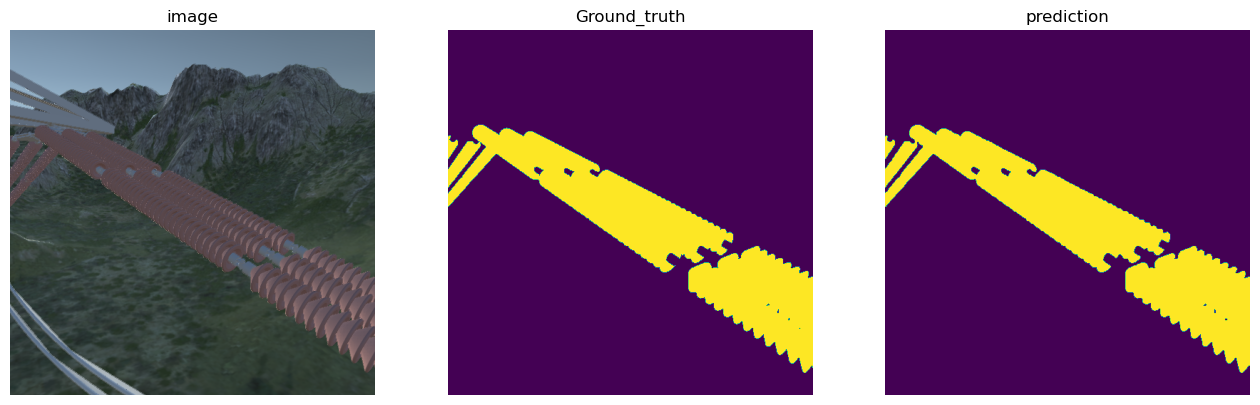

In [23]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [24]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg16_polymer.pth')

In [25]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/linknet_vgg16_polymer.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_10744\3051025730.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [26]:
model.to('cuda')

Linknet(
  (encoder): VGGEncoder(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
   

In [27]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [28]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [29]:
real_data = SegmentDataset(dir,2,transform=transform )

In [30]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [31]:
#images, masks = next(iter(real_dataloader))

In [32]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [33]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [34]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [35]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()